# CXCR7 Platelet Analysis — Data Preparation (Proteome + Phosphoproteome)

This notebook:
1. Loads normalized intensity and log₂FC tables for proteome and phosphoproteome.  
2. Parses timepoints and conditions (CXCR7, DMSO).  
3. Applies minimum-expression filtering.  
4. Integrates both layers into per-timepoint/per-condition expression tables (`expr_mean`).  
5. Exports results for downstream OmniPath network reconstruction.

## 1. Setup and Imports

In [52]:
!pwd

/storage/users/job37yv/Projects/CXCR7_platelet_analysis/scripts/integrated_network_analysis


In [99]:
!cd /storage/users/job37yv/Projects/CXCR7_platelet_analysis

In [100]:
import pandas as pd
from pathlib import Path
import re
from mygene import MyGeneInfo

mg = MyGeneInfo()

# === Base paths ===
base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
proteo_path = base / "proteomics" / "data" / "processed_data"
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

print(proteo_path, phospho_path, sep="\n")

# === Load proteomics ===
prot_intensity = pd.read_csv(proteo_path / "norm_intensity.txt", sep="\t", index_col=0)
prot_fc = pd.read_csv(proteo_path / "top.all.txt", sep="\t", index_col=0)

# === Load phosphoproteomics ===
phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)
phospho_fc = pd.read_csv(phospho_path / "top.all.txt", sep="\t", index_col=0)

print(f"Loaded {phospho_intensity.shape[0]} phosphosites, {prot_intensity.shape[0]} proteins")


/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation/proteomics/data/processed_data
/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation/phosphoproteomics/data/processed_data
Loaded 3772 phosphosites, 2326 proteins


In [101]:
# Verify example entries
prot_intensity.head(3)

,0000_Ctrl_1,0000_Ctrl_10,0000_Ctrl_2,0000_Ctrl_3,0000_Ctrl_4,0000_Ctrl_5,0000_Ctrl_6,0000_Ctrl_7,0000_Ctrl_8,0000_Ctrl_9,...,1800_DMSO_1,1800_DMSO_10,1800_DMSO_2,1800_DMSO_3,1800_DMSO_4,1800_DMSO_5,1800_DMSO_6,1800_DMSO_7,1800_DMSO_8,1800_DMSO_9
P21333,34.368754,34.298416,34.345731,34.325200,34.293794,34.355262,34.356371,34.370990,34.318529,34.291249,...,34.309026,34.328435,34.307772,34.315982,34.309166,34.341564,34.241180,34.308330,34.325987,34.370428
Q9Y490,32.931660,32.815661,32.877635,32.838257,32.844331,32.880702,32.870414,32.898564,32.881153,32.828138,...,32.831031,32.898825,32.863700,32.889887,32.906386,32.852022,32.900556,32.855240,32.844584,32.885300
P35579,31.674445,31.691832,31.691225,31.665338,31.666706,31.664386,31.689454,31.727621,31.720968,31.660617,...,31.692726,31.738571,31.653651,31.706043,31.678516,31.690525,31.731300,31.628909,31.630523,31.658926


In [102]:
phospho_intensity.head(5)

,x0sek_Ctrl_01,x0sek_Ctrl_02,x0sek_Ctrl_03,x0sek_Ctrl_04,x0sek_Ctrl_05,x0sek_Ctrl_06,x0sek_Ctrl_07,x0sek_Ctrl_08,x0sek_Ctrl_09,x0sek_Ctrl_10,...,x600sek_DMSO_01,x600sek_DMSO_02,x600sek_DMSO_03,x600sek_DMSO_04,x600sek_DMSO_05,x600sek_DMSO_06,x600sek_DMSO_07,x600sek_DMSO_08,x600sek_DMSO_09,x600sek_DMSO_10
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1,13.597979,13.918964,13.303412,13.320175,14.597456,13.396662,13.620080,13.689456,13.737232,13.546165,...,13.769600,14.373377,13.639081,14.212860,14.265102,14.331915,14.050113,14.214666,13.625749,14.262618
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4,13.612067,13.489626,13.312046,13.943136,13.445734,12.929919,13.197739,13.358574,13.334468,13.410675,...,13.796932,13.451161,13.690133,13.643945,13.533801,13.768681,13.917045,13.680197,13.882320,13.781813
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5,38.084983,39.743858,39.907811,40.186267,38.515840,38.389777,39.924240,40.178919,39.780751,39.438996,...,39.156226,40.026918,40.410512,39.457426,40.054131,40.478940,40.425533,37.957648,41.318694,39.773858
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10,18.057984,17.615148,19.516947,18.045793,18.909073,17.275418,18.401392,17.889053,18.078644,18.261259,...,18.055928,18.146103,18.118123,17.012727,18.578787,18.601212,17.961748,19.153783,18.964489,16.808317
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11,16.429011,17.146357,16.727113,17.199776,17.371291,17.383012,17.068876,16.641918,17.213817,16.996345,...,17.812551,17.522332,17.193356,17.231007,17.001460,17.326506,18.198516,17.226246,17.442948,17.922485


In [103]:
prot_fc.head(5)

,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800
A0A075B6I0,0.229630,0.326486,0.999876,0.148452,0.513700,0.999896,-0.030090,0.894522,0.9993
A0A0A0MS15,0.087997,0.869758,0.999876,-0.130536,0.802694,0.999896,-0.031189,0.952384,0.9993
A0A0B4J1U7,0.018450,0.967442,0.999876,0.020623,0.962613,0.999896,0.044284,0.919826,0.9993
A0A0B4J1X5,0.119885,0.604642,0.999876,0.015170,0.946281,0.999896,0.109947,0.625630,0.9993
A0A0B4J1Y9,0.073269,0.750885,0.999876,0.126968,0.572246,0.999896,0.031596,0.888107,0.9993


In [104]:
phospho_fc.head(5)

,uniprot,symbol,"logFC,10","P,Value,10","adj,P,Val,10","logFC,600","P,Value,600","adj,P,Val,600","logFC,1800","P,Value,1800","adj,P,Val,1800"
A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHKKTPFTQTSDLQR;6482,A0A1B0GUW6,NaN,"-0,487629835120362","0,237963577503289","0,60932691785442","-0,121131895821936","0,768297038855246","0,940299821558624","-1,18280090654232","0,00522244646966009","0,0700030058699118"
A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPGMEEK;380,A0FGR8,ESYT2,"0,112968311937788","0,561838288693443","0,836479200987377","-0,631699084389012","0,00175793485383191","0,0614956921686285","0,0245671040872111","0,899486493453842","0,951118648667205"
A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581,A0FGR8,ESYT2,"-0,336258436934905","0,216694771253843","0,585515673594888","0,364800791696606","0,18061397273498","0,546526430466077","0,488185081244218","0,0747047911625459","0,302857261469781"
A0FGR8;ESYT2;S739;SSSSLLASPGHISVK;2582,A0FGR8,ESYT2,"0,214166222409084","0,0987260382351089","0,41905016854542","0,16221747222451","0,209094491293291","0,569764401015454","0,333042093245436","0,0113570699773983","0,106867529288619"
A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736,A0FGR8,ESYT2,"0,177453611441644","0,753408821344539","0,9184553380203","0,484827910802389","0,391869520870555","0,741376824399716","0,658352877586731","0,246055433492464","0,541253223115407"


## 2. prepare tables

### 2.1 extract UniProt + symbol + collapse by max |logFC|

In [105]:
# === Extract UniProt and gene symbol from phosphosite IDs ===
phospho_fc["UniProt"] = phospho_fc.index.str.split(";").str[0]
phospho_fc["gene_symbol"] = phospho_fc.index.str.split(";").str[1]
phospho_fc["psite_id"] = phospho_fc.index

# === Identify logFC columns for CXCR7 stimulation ===
cxcr7_cols = [c for c in phospho_fc.columns if "cxcr7" in c.lower()]

# Compute maximum absolute logFC across CXCR7 conditions
phospho_fc["abs_max_logFC"] = phospho_fc[cxcr7_cols].abs().max(axis=1)

# For each UniProt, pick site with the largest |logFC|
collapsed = (
    phospho_fc
    .sort_values("abs_max_logFC", ascending=False)
    .groupby("UniProt", group_keys=False)
    .head(1)
)

print(f"Collapsed from {len(phospho_fc)} → {len(collapsed)} sites")


Collapsed from 3150 → 1315 sites


### 2.2 filter phospho_intensity to selected sites

In [106]:
# Keep only selected sites
phospho_intensity = phospho_intensity.loc[collapsed["psite_id"].values]

# Add UniProt + gene symbol columns
phospho_intensity["UniProt"] = collapsed["UniProt"].values
phospho_intensity["gene_symbol"] = collapsed["gene_symbol"].values
phospho_intensity["psite_id"] = phospho_intensity.index

# Set a MultiIndex: (UniProt, psite_id)
phospho_intensity = phospho_intensity.set_index(["UniProt", "psite_id"])

phospho_intensity.head(9)


,,x0sek_Ctrl_01,x0sek_Ctrl_02,x0sek_Ctrl_03,x0sek_Ctrl_04,x0sek_Ctrl_05,x0sek_Ctrl_06,x0sek_Ctrl_07,x0sek_Ctrl_08,x0sek_Ctrl_09,x0sek_Ctrl_10,...,x600sek_DMSO_02,x600sek_DMSO_03,x600sek_DMSO_04,x600sek_DMSO_05,x600sek_DMSO_06,x600sek_DMSO_07,x600sek_DMSO_08,x600sek_DMSO_09,x600sek_DMSO_10,gene_symbol
UniProt,psite_id,,,,,,,,,,,,,,,,,,,,,
A0A1B0GUW6,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHKKTPFTQTSDLQR;6482,19.523117,19.264776,20.209760,19.396255,18.945087,19.386769,18.989624,19.144782,18.339918,19.239764,...,20.543774,19.319025,20.698126,18.147171,19.088685,18.510881,19.976539,18.618213,19.798579,NA
A0FGR8,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPGMEEK;380,23.921173,23.301198,23.695448,23.756590,23.195117,23.485916,23.684260,23.638739,23.192471,23.487659,...,23.410170,23.774427,23.586027,23.514173,23.269015,23.331905,23.528085,23.138065,23.376599,ESYT2
A1A4S6,A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664,19.061895,18.940718,19.079970,18.779057,18.742247,18.715497,18.815968,18.974898,18.841471,18.904230,...,19.006727,18.520417,19.243249,19.082168,19.123002,19.152678,18.884779,18.403784,18.988816,ARHGAP10
A1L390,A1L390;PLEKHG3;S1037;SPLSPTETFSWPDVR;2308,20.410910,21.662725,21.936781,21.896007,22.582868,21.710460,21.811400,21.976826,21.226846,21.663974,...,21.149303,20.633137,21.067520,21.449178,21.507883,22.184602,21.471563,22.746704,21.500282,PLEKHG3
A2A2Y4,A2A2Y4;FRMD3;S429;EYEDPPSEEEDKIK;6127,11.538782,11.591712,13.405905,10.589459,13.054422,12.247482,12.191009,12.571698,12.442225,12.302189,...,11.325533,12.163245,12.441425,12.943697,13.155300,13.130525,13.453713,12.193593,12.749219,FRMD3
A2RRP1,A2RRP1;NBAS;S473;AGEEDEGEEDSDSDYEISAK;4095,18.675707,18.491597,18.409412,18.420264,18.499704,18.209160,18.326156,18.559509,18.624043,18.506356,...,18.255436,18.658485,17.915290,18.026796,18.284812,18.992738,18.122178,18.304267,18.318133,NBAS
A2RUS2,A2RUS2;DENND3;S472;MVVSMPNLQDIAMPELAPR;1232,38.573379,38.076961,38.846221,38.751104,38.632617,38.218117,38.745346,38.246038,38.365155,38.490782,...,37.742580,38.761763,36.017295,38.450607,39.002503,38.039344,37.708243,38.261708,37.833955,DENND3
A6NFX1,A6NFX1;MFSD2B;S12;GSPQPEPHAPEPGPGSAK;3119,16.711410,16.726981,16.942728,16.574954,16.712118,16.583476,16.850222,16.812212,16.882920,16.803332,...,16.623756,16.740751,17.168158,17.129974,16.764427,16.842251,17.229846,17.015201,16.914867,MFSD2B
A6QL63,A6QL63;ABTB3;S65;HNSFDTVNTALVEDSEGLDCAGQHCSR;4382,35.218750,35.964619,36.539511,37.215466,36.147690,35.895188,35.940029,36.515334,35.634549,36.207324,...,36.747055,36.743548,36.469037,35.734662,36.563154,35.791503,35.573110,36.807992,37.354930,ABTB3


### 2.3 map gene symbols for proteome 

In [107]:
from mygene import MyGeneInfo
import pandas as pd

mg = MyGeneInfo()

# --- 1️⃣ PROTEOME intensity ---
prot_intensity = prot_intensity.copy()
uniprot_ids = prot_intensity.index.tolist()

# Query MyGeneInfo
query_res = mg.querymany(uniprot_ids, scopes="uniprot", fields="symbol", species="human", as_dataframe=True)
symbol_map = query_res["symbol"].to_dict()

prot_intensity["gene_symbol"] = prot_intensity.index.map(symbol_map)
prot_intensity["gene_symbol"] = prot_intensity["gene_symbol"].fillna(prot_intensity.index.to_series())

print(f"[Proteome] Gene symbols found: {prot_intensity['gene_symbol'].notna().sum()} / {len(prot_intensity)}")

# --- 2️⃣ PHOSPHOPROTEOME intensity ---
phospho_intensity = phospho_intensity.copy()
if isinstance(phospho_intensity.index, pd.MultiIndex):
    phospho_intensity.reset_index(inplace=True)
    phospho_intensity = phospho_intensity.set_index("UniProt")

# If missing gene_symbol, try to extract from index
if "gene_symbol" not in phospho_intensity.columns:
    phospho_intensity["gene_symbol"] = phospho_intensity.index.to_series().str.split(";").str[1]

# Fallback to UniProt if missing
phospho_intensity["gene_symbol"] = phospho_intensity["gene_symbol"].replace(["NA", "NaN", None], pd.NA)
phospho_intensity["gene_symbol"] = phospho_intensity["gene_symbol"].fillna(phospho_intensity.index.to_series())

print(f"[Phosphoproteome] Gene symbols filled: {phospho_intensity['gene_symbol'].notna().sum()} / {len(phospho_intensity)}")

# --- 3️⃣ PROTEOME FC ---
prot_fc = prot_fc.copy()
prot_fc["gene_symbol"] = prot_fc.index.map(symbol_map)
prot_fc["gene_symbol"] = prot_fc["gene_symbol"].fillna(prot_fc.index.to_series())

print(f"[Proteome FC] Gene symbols found: {prot_fc['gene_symbol'].notna().sum()} / {len(prot_fc)}")

# --- 4️⃣ PHOSPHOPROTEOME FC ---
phospho_fc = phospho_fc.copy()
phospho_fc["UniProt"] = phospho_fc.index.str.split(";").str[0]
phospho_fc["gene_symbol"] = phospho_fc.index.str.split(";").str[1]
phospho_fc["psite_id"] = phospho_fc.index

# Fill missing
phospho_fc["gene_symbol"] = phospho_fc["gene_symbol"].replace(["NA", "NaN", None], pd.NA)
phospho_fc["gene_symbol"] = phospho_fc["gene_symbol"].fillna(phospho_fc["UniProt"])
phospho_fc = phospho_fc.set_index("UniProt")

print(f"[Phosphoproteome FC] Gene symbols filled: {phospho_fc['gene_symbol'].notna().sum()} / {len(phospho_fc)}")




Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
10 input query terms found dup hits:	[('P0C0L5', 2), ('P0C0L4', 2), ('P0DMV9', 2), ('P69905', 2), ('P0DP24', 3), ('Q9H3K6', 2), ('P23610'
20 input query terms found no hit:	['P01857', 'P01871', 'P01859', 'P01876', 'P01860', 'P01834', 'P01861', 'A6NIZ1', 'P01877', 'P01880',


[Proteome] Gene symbols found: 2326 / 2326
[Phosphoproteome] Gene symbols filled: 1315 / 1315
[Proteome FC] Gene symbols found: 2326 / 2326
[Phosphoproteome FC] Gene symbols filled: 3150 / 3150


In [108]:
print("=== PROTEOME intensity ===")
display(prot_intensity.head(3))

print("\n=== PHOSPHOPROTEOME intensity (collapsed sites) ===")
display(phospho_intensity.head(3))

print("\n=== PROTEOME log2FC ===")
display(prot_fc.head(14))

print("\n=== PHOSPHOPROTEOME log2FC (collapsed sites) ===")
display(collapsed.head(14))


=== PROTEOME intensity ===


,0000_Ctrl_1,0000_Ctrl_10,0000_Ctrl_2,0000_Ctrl_3,0000_Ctrl_4,0000_Ctrl_5,0000_Ctrl_6,0000_Ctrl_7,0000_Ctrl_8,0000_Ctrl_9,...,1800_DMSO_10,1800_DMSO_2,1800_DMSO_3,1800_DMSO_4,1800_DMSO_5,1800_DMSO_6,1800_DMSO_7,1800_DMSO_8,1800_DMSO_9,gene_symbol
P21333,34.368754,34.298416,34.345731,34.325200,34.293794,34.355262,34.356371,34.370990,34.318529,34.291249,...,34.328435,34.307772,34.315982,34.309166,34.341564,34.241180,34.308330,34.325987,34.370428,FLNA
Q9Y490,32.931660,32.815661,32.877635,32.838257,32.844331,32.880702,32.870414,32.898564,32.881153,32.828138,...,32.898825,32.863700,32.889887,32.906386,32.852022,32.900556,32.855240,32.844584,32.885300,TLN1
P35579,31.674445,31.691832,31.691225,31.665338,31.666706,31.664386,31.689454,31.727621,31.720968,31.660617,...,31.738571,31.653651,31.706043,31.678516,31.690525,31.731300,31.628909,31.630523,31.658926,MYH9



=== PHOSPHOPROTEOME intensity (collapsed sites) ===


,psite_id,x0sek_Ctrl_01,x0sek_Ctrl_02,x0sek_Ctrl_03,x0sek_Ctrl_04,x0sek_Ctrl_05,x0sek_Ctrl_06,x0sek_Ctrl_07,x0sek_Ctrl_08,x0sek_Ctrl_09,...,x600sek_DMSO_02,x600sek_DMSO_03,x600sek_DMSO_04,x600sek_DMSO_05,x600sek_DMSO_06,x600sek_DMSO_07,x600sek_DMSO_08,x600sek_DMSO_09,x600sek_DMSO_10,gene_symbol
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A1B0GUW6,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,19.523117,19.264776,20.209760,19.396255,18.945087,19.386769,18.989624,19.144782,18.339918,...,20.543774,19.319025,20.698126,18.147171,19.088685,18.510881,19.976539,18.618213,19.798579,A0A1B0GUW6
A0FGR8,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,23.921173,23.301198,23.695448,23.756590,23.195117,23.485916,23.684260,23.638739,23.192471,...,23.410170,23.774427,23.586027,23.514173,23.269015,23.331905,23.528085,23.138065,23.376599,ESYT2
A1A4S6,A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664,19.061895,18.940718,19.079970,18.779057,18.742247,18.715497,18.815968,18.974898,18.841471,...,19.006727,18.520417,19.243249,19.082168,19.123002,19.152678,18.884779,18.403784,18.988816,ARHGAP10



=== PROTEOME log2FC ===


,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800,gene_symbol
A0A075B6I0,0.229630,0.326486,0.999876,0.148452,0.513700,0.999896,-0.030090,0.894522,0.9993,A0A075B6I0
A0A0A0MS15,0.087997,0.869758,0.999876,-0.130536,0.802694,0.999896,-0.031189,0.952384,0.9993,A0A0A0MS15
A0A0B4J1U7,0.018450,0.967442,0.999876,0.020623,0.962613,0.999896,0.044284,0.919826,0.9993,A0A0B4J1U7
A0A0B4J1X5,0.119885,0.604642,0.999876,0.015170,0.946281,0.999896,0.109947,0.625630,0.9993,A0A0B4J1X5
A0A0B4J1Y9,0.073269,0.750885,0.999876,0.126968,0.572246,0.999896,0.031596,0.888107,0.9993,A0A0B4J1Y9
A0A0C4DH43,0.543994,0.253013,0.999876,0.597408,0.197773,0.999896,0.075451,0.869968,0.9993,A0A0C4DH43
A0AVT1,-0.039075,0.757506,0.999876,0.066469,0.589753,0.999896,0.002634,0.982934,0.9993,UBA6
A0FGR8,-0.018754,0.889416,0.999876,-0.038928,0.766891,0.999896,0.003813,0.976827,0.9993,ESYT2
A1A4S6,-0.063844,0.642403,0.999876,-0.047758,0.721102,0.999896,-0.013804,0.917777,0.9993,ARHGAP10
A1L0T0,0.360406,0.377997,0.999876,0.007369,0.985179,0.999896,-0.413941,0.298775,0.9993,HACL2



=== PHOSPHOPROTEOME log2FC (collapsed sites) ===


,uniprot,symbol,"logFC,10","P,Value,10","adj,P,Val,10","logFC,600","P,Value,600","adj,P,Val,600","logFC,1800","P,Value,1800","adj,P,Val,1800",UniProt,gene_symbol,psite_id,abs_max_logFC
A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHKKTPFTQTSDLQR;6482,A0A1B0GUW6,NaN,"-0,487629835120362","0,237963577503289","0,60932691785442","-0,121131895821936","0,768297038855246","0,940299821558624","-1,18280090654232","0,00522244646966009","0,0700030058699118",A0A1B0GUW6,NA,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,NaN
A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPGMEEK;380,A0FGR8,ESYT2,"0,112968311937788","0,561838288693443","0,836479200987377","-0,631699084389012","0,00175793485383191","0,0614956921686285","0,0245671040872111","0,899486493453842","0,951118648667205",A0FGR8,ESYT2,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,NaN
A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664,A1A4S6,ARHGAP10,"-0,0957207066659826","0,304305686720043","0,679831853310735","0,13454498397445","0,150338762282698","0,507147669681886","0,179922661303898","0,0558981354231882","0,259321246808605",A1A4S6,ARHGAP10,A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664,NaN
A1L390;PLEKHG3;S1037;SPLSPTETFSWPDVR;2308,A1L390,PLEKHG3,"-0,279061278565873","0,184540940272178","0,546338310016318","0,242789861301468","0,247559074248242","0,616939148640792","0,176981086058603","0,398178245231925","0,682405588944811",A1L390,PLEKHG3,A1L390;PLEKHG3;S1037;SPLSPTETFSWPDVR;2308,NaN
A2A2Y4;FRMD3;S429;EYEDPPSEEEDKIK;6127,A2A2Y4,FRMD3,"0,111166672172597","0,659444494681948","0,87659253738168","-0,126157669658358","0,617074475206251","0,877057361337844","0,839884777714754","0,0013591327142705","0,0348070573166835",A2A2Y4,FRMD3,A2A2Y4;FRMD3;S429;EYEDPPSEEEDKIK;6127,NaN
A2RRP1;NBAS;S473;AGEEDEGEEDSDSDYEISAK;4095,A2RRP1,NBAS,"0,056870392470902","0,609051081766744","0,85248219823807","0,0521516121138106","0,639021811510424","0,885636801616607","-0,0332171117045164","0,765006803925718","0,896825988971348",A2RRP1,NBAS,A2RRP1;NBAS;S473;AGEEDEGEEDSDSDYEISAK;4095,NaN
A2RUS2;DENND3;S472;MVVSMPNLQDIAMPELAPR;1232,A2RUS2,DENND3,"-0,263900567074181","0,394790478591843","0,746359906935359","-0,113226100115966","0,714423041752993","0,920183955454603","-0,0451025412309605","0,88406038818647","0,943365928573587",A2RUS2,DENND3,A2RUS2;DENND3;S472;MVVSMPNLQDIAMPELAPR;1232,NaN
A6NFX1;MFSD2B;S12;GSPQPEPHAPEPGPGSAK;3119,A6NFX1,MFSD2B,"0,0291448802819865","0,751397630809649","0,9184553380203","-0,0647670397177009","0,482087102197277","0,806465412597676","-0,0382799056306169","0,677426355646191","0,856818313483549",A6NFX1,MFSD2B,A6NFX1;MFSD2B;S12;GSPQPEPHAPEPGPGSAK;3119,NaN
A6QL63;ABTB3;S65;HNSFDTVNTALVEDSEGLDCAGQHCSR;4382,A6QL63,ABTB3,"0,376705822307862","0,167308769194497","0,524970680187784","0,516953451979788","0,0596739457349389","0,35846674033903","-0,00342306783305446","0,989915585524473","0,994843567244971",A6QL63,ABTB3,A6QL63;ABTB3;S65;HNSFDTVNTALVEDSEGLDCAGQHCSR;4382,NaN
A7E2V4;ZSWIM8;S1092;NVPESSPHSPCEGLPSEAALTPRPEGK;1069,A7E2V4,ZSWIM8,"-0,252291538271624","0,409255735067225","0,753476577581264","-0,941240286981063","0,00285328912038934","0,0785556617005016","0,24935748358822","0,414697033419566","0,69299504258442",A7E2V4,ZSWIM8,A7E2V4;ZSWIM8;S1092;NVPESSPHSPCEGLPSEAALTPRPEG...,NaN


### 2.4 normalize and clean data structures

In [109]:
import numpy as np

# ===========================================
# 🧹 Helper: Clean numeric columns
# ===========================================
def clean_numeric(df):
    """Convert object columns to float if possible, replacing commas with dots."""
    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = (
                    df[col]
                    .astype(str)
                    .str.replace(",", ".", regex=False)
                    .astype(float)
                )
            except ValueError:
                pass
    return df


# ===========================================
# 🧩 1. Proteome intensity
# ===========================================
prot_intensity = prot_intensity.copy()
prot_intensity["gene_symbol"] = prot_intensity["gene_symbol"].fillna(prot_intensity.index.to_series())
prot_intensity = clean_numeric(prot_intensity)
prot_intensity = prot_intensity.sort_index()
prot_intensity.index.name = "UniProt"


# ===========================================
# 🧩 2. Phosphoproteome intensity
# ===========================================
phospho_intensity = phospho_intensity.copy()
phospho_intensity["gene_symbol"] = phospho_intensity["gene_symbol"].replace(["NA", "NaN", None, np.nan], np.nan)
phospho_intensity["gene_symbol"] = phospho_intensity["gene_symbol"].fillna(phospho_intensity.index.to_series())
phospho_intensity = clean_numeric(phospho_intensity)

# Ensure UniProt is the main index
if isinstance(phospho_intensity.index, pd.MultiIndex):
    phospho_intensity.reset_index(inplace=True)
    phospho_intensity = phospho_intensity.set_index("UniProt")

phospho_intensity = phospho_intensity.sort_index()
phospho_intensity.index.name = "UniProt"


# ===========================================
# 🧩 3. Proteome FC
# ===========================================
prot_fc = prot_fc.copy()
prot_fc["gene_symbol"] = prot_fc["gene_symbol"].fillna(prot_fc.index.to_series())
prot_fc = clean_numeric(prot_fc)
prot_fc = prot_fc.sort_index()
prot_fc.index.name = "UniProt"


# ===========================================
# 🧩 4. Phosphoproteome FC
# ===========================================
phospho_fc = phospho_fc.copy()
phospho_fc["gene_symbol"] = phospho_fc["gene_symbol"].replace(["NA", "NaN", None, np.nan], np.nan)
phospho_fc["gene_symbol"] = phospho_fc["gene_symbol"].fillna(phospho_fc.index.to_series())
phospho_fc = clean_numeric(phospho_fc)

# Ensure UniProt index and proper column order
if "psite_id" in phospho_fc.columns:
    phospho_fc = phospho_fc[
        [c for c in phospho_fc.columns if c not in ["gene_symbol", "psite_id"]]
        + ["psite_id", "gene_symbol"]
    ]
else:
    phospho_fc = phospho_fc[
        [c for c in phospho_fc.columns if c != "gene_symbol"] + ["gene_symbol"]
    ]

phospho_fc = phospho_fc.sort_index()
phospho_fc.index.name = "UniProt"





In [110]:
# ===========================================
# ✅ 5. Summary + sanity check
# ===========================================
print("=== Normalized PROTEOME intensity ===")
display(prot_intensity.head(3))

print("\n=== Normalized PHOSPHOPROTEOME intensity ===")
display(phospho_intensity.head(3))

print("\n=== Normalized PROTEOME FC ===")
display(prot_fc.head(3))

print("\n=== Normalized PHOSPHOPROTEOME FC ===")
display(phospho_fc.head(3))

print("\n✅ All four datasets harmonized and ready for downstream analysis.")

=== Normalized PROTEOME intensity ===


,0000_Ctrl_1,0000_Ctrl_10,0000_Ctrl_2,0000_Ctrl_3,0000_Ctrl_4,0000_Ctrl_5,0000_Ctrl_6,0000_Ctrl_7,0000_Ctrl_8,0000_Ctrl_9,...,1800_DMSO_10,1800_DMSO_2,1800_DMSO_3,1800_DMSO_4,1800_DMSO_5,1800_DMSO_6,1800_DMSO_7,1800_DMSO_8,1800_DMSO_9,gene_symbol
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,32.228574,32.432434,32.252325,32.080299,32.121563,32.199316,32.180987,32.262201,32.307101,32.274602,...,32.112993,32.606037,32.176807,32.034529,32.440609,32.373951,32.211548,32.178385,32.431773,A0A075B6I0
A0A0A0MS15,22.030421,22.592599,21.590172,22.502251,21.587134,22.183902,22.583112,22.978310,23.001468,22.646823,...,21.434047,22.714268,23.515449,22.354847,23.367496,22.143902,22.893127,22.678624,22.652957,A0A0A0MS15
A0A0B4J1U7,13.450772,13.539195,13.488165,13.498254,13.585720,13.479135,13.648243,13.477694,13.602864,13.558177,...,13.554700,13.499870,13.612859,13.461248,13.644306,13.636720,13.517841,13.472831,13.432458,A0A0B4J1U7



=== Normalized PHOSPHOPROTEOME intensity ===


,psite_id,x0sek_Ctrl_01,x0sek_Ctrl_02,x0sek_Ctrl_03,x0sek_Ctrl_04,x0sek_Ctrl_05,x0sek_Ctrl_06,x0sek_Ctrl_07,x0sek_Ctrl_08,x0sek_Ctrl_09,...,x600sek_DMSO_02,x600sek_DMSO_03,x600sek_DMSO_04,x600sek_DMSO_05,x600sek_DMSO_06,x600sek_DMSO_07,x600sek_DMSO_08,x600sek_DMSO_09,x600sek_DMSO_10,gene_symbol
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A1B0GUW6,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,19.523117,19.264776,20.209760,19.396255,18.945087,19.386769,18.989624,19.144782,18.339918,...,20.543774,19.319025,20.698126,18.147171,19.088685,18.510881,19.976539,18.618213,19.798579,A0A1B0GUW6
A0FGR8,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,23.921173,23.301198,23.695448,23.756590,23.195117,23.485916,23.684260,23.638739,23.192471,...,23.410170,23.774427,23.586027,23.514173,23.269015,23.331905,23.528085,23.138065,23.376599,ESYT2
A1A4S6,A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664,19.061895,18.940718,19.079970,18.779057,18.742247,18.715497,18.815968,18.974898,18.841471,...,19.006727,18.520417,19.243249,19.082168,19.123002,19.152678,18.884779,18.403784,18.988816,ARHGAP10



=== Normalized PROTEOME FC ===


,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800,gene_symbol
UniProt,,,,,,,,,,
A0A075B6I0,0.229630,0.326486,0.999876,0.148452,0.513700,0.999896,-0.030090,0.894522,0.9993,A0A075B6I0
A0A0A0MS15,0.087997,0.869758,0.999876,-0.130536,0.802694,0.999896,-0.031189,0.952384,0.9993,A0A0A0MS15
A0A0B4J1U7,0.018450,0.967442,0.999876,0.020623,0.962613,0.999896,0.044284,0.919826,0.9993,A0A0B4J1U7



=== Normalized PHOSPHOPROTEOME FC ===


,uniprot,symbol,"logFC,10","P,Value,10","adj,P,Val,10","logFC,600","P,Value,600","adj,P,Val,600","logFC,1800","P,Value,1800","adj,P,Val,1800",abs_max_logFC,psite_id,gene_symbol
UniProt,,,,,,,,,,,,,,
A0A1B0GUW6,A0A1B0GUW6,NaN,-0.487630,0.237964,0.609327,-0.121132,0.768297,0.940300,-1.182801,0.005222,0.070003,NaN,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,A0A1B0GUW6
A0FGR8,A0FGR8,ESYT2,0.112968,0.561838,0.836479,-0.631699,0.001758,0.061496,0.024567,0.899486,0.951119,NaN,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,ESYT2
A0FGR8,A0FGR8,ESYT2,-0.336258,0.216695,0.585516,0.364801,0.180614,0.546526,0.488185,0.074705,0.302857,NaN,A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581,ESYT2



✅ All four datasets harmonized and ready for downstream analysis.


In [111]:
# =======================================================
# 🧩 1. Clean column names globally
# =======================================================
def clean_columns(df):
    """Standardize column names: replace commas with dots, strip spaces."""
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace(" ", "_", regex=False)
        .str.strip()
    )
    return df


# =======================================================
# 🧩 2. Proteome intensity
# =======================================================
prot_intensity = clean_columns(prot_intensity)

# unify time labels like 'x0sek_Ctrl_01' → '0000_Ctrl_01'
prot_intensity.columns = [
    col.replace("x0sek", "0000")
    .replace("x10sek", "0010")
    .replace("x600sek", "0600")
    .replace("x1800sek", "1800")
    for col in prot_intensity.columns
]


# =======================================================
# 🧩 3. Phosphoproteome intensity
# =======================================================
phospho_intensity = clean_columns(phospho_intensity)

# unify time naming pattern (if present)
phospho_intensity.columns = [
    col.replace("x0sek", "0000")
    .replace("x10sek", "0010")
    .replace("x600sek", "0600")
    .replace("x1800sek", "1800")
    for col in phospho_intensity.columns
]

# optional: ensure consistent naming order
phospho_intensity = phospho_intensity.sort_index(axis=1)


# =======================================================
# 🧩 4. Proteome FC
# =======================================================
prot_fc = clean_columns(prot_fc)

# Harmonize column order (logFC → P.Value → adj.P.Val)
fc_cols = [c for c in prot_fc.columns if "logFC" in c or "P.Value" in c or "adj.P.Val" in c]
prot_fc = prot_fc[fc_cols + ["gene_symbol"]]


# =======================================================
# 🧩 5. Phosphoproteome FC
# =======================================================
phospho_fc = clean_columns(phospho_fc)

# Drop redundant/unnecessary columns if present
drop_cols = [c for c in ["uniprot", "symbol", "abs_max_logFC", "UniProt"] if c in phospho_fc.columns]
phospho_fc = phospho_fc.drop(columns=drop_cols, errors="ignore")

# Keep only the main FC-related columns + psite_id + gene_symbol
keep_cols = [c for c in phospho_fc.columns if any(x in c for x in ["logFC", "P.Value", "adj.P.Val"])]
if "psite_id" in phospho_fc.columns:
    keep_cols += ["psite_id"]
if "gene_symbol" in phospho_fc.columns:
    keep_cols += ["gene_symbol"]

phospho_fc = phospho_fc[keep_cols]

# Sort by index
phospho_fc = phospho_fc.sort_index()


# =======================================================
# ✅ 6. Sanity check
# =======================================================
print("=== Cleaned PROTEOME intensity ===")
display(prot_intensity.head(3))

print("\n=== Cleaned PHOSPHOPROTEOME intensity ===")
display(phospho_intensity.head(3))

print("\n=== Cleaned PROTEOME FC ===")
display(prot_fc.head(3))

print("\n=== Cleaned PHOSPHOPROTEOME FC ===")
display(phospho_fc.head(3))

print("\n✅ Column names harmonized and redundant columns removed.")


=== Cleaned PROTEOME intensity ===


,0000_Ctrl_1,0000_Ctrl_10,0000_Ctrl_2,0000_Ctrl_3,0000_Ctrl_4,0000_Ctrl_5,0000_Ctrl_6,0000_Ctrl_7,0000_Ctrl_8,0000_Ctrl_9,...,1800_DMSO_10,1800_DMSO_2,1800_DMSO_3,1800_DMSO_4,1800_DMSO_5,1800_DMSO_6,1800_DMSO_7,1800_DMSO_8,1800_DMSO_9,gene_symbol
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,32.228574,32.432434,32.252325,32.080299,32.121563,32.199316,32.180987,32.262201,32.307101,32.274602,...,32.112993,32.606037,32.176807,32.034529,32.440609,32.373951,32.211548,32.178385,32.431773,A0A075B6I0
A0A0A0MS15,22.030421,22.592599,21.590172,22.502251,21.587134,22.183902,22.583112,22.978310,23.001468,22.646823,...,21.434047,22.714268,23.515449,22.354847,23.367496,22.143902,22.893127,22.678624,22.652957,A0A0A0MS15
A0A0B4J1U7,13.450772,13.539195,13.488165,13.498254,13.585720,13.479135,13.648243,13.477694,13.602864,13.558177,...,13.554700,13.499870,13.612859,13.461248,13.644306,13.636720,13.517841,13.472831,13.432458,A0A0B4J1U7



=== Cleaned PHOSPHOPROTEOME intensity ===


,0000_Ctrl_01,0000_Ctrl_02,0000_Ctrl_03,0000_Ctrl_04,0000_Ctrl_05,0000_Ctrl_06,0000_Ctrl_07,0000_Ctrl_08,0000_Ctrl_09,0000_Ctrl_10,...,1800_DMSO_03,1800_DMSO_04,1800_DMSO_05,1800_DMSO_06,1800_DMSO_07,1800_DMSO_08,1800_DMSO_09,1800_DMSO_10,gene_symbol,psite_id
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A1B0GUW6,19.523117,19.264776,20.209760,19.396255,18.945087,19.386769,18.989624,19.144782,18.339918,19.239764,...,18.752689,22.854081,19.613200,19.378703,19.205551,21.410893,18.584444,19.534940,A0A1B0GUW6,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...
A0FGR8,23.921173,23.301198,23.695448,23.756590,23.195117,23.485916,23.684260,23.638739,23.192471,23.487659,...,23.403477,22.596842,22.998345,23.337193,23.621927,23.115813,24.161559,23.467255,ESYT2,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...
A1A4S6,19.061895,18.940718,19.079970,18.779057,18.742247,18.715497,18.815968,18.974898,18.841471,18.904230,...,18.661278,19.125682,18.758153,18.953166,19.224859,18.818540,19.217893,18.935159,ARHGAP10,A1A4S6;ARHGAP10;S591;TPPDTTFPEPTCLSASPPNAPPR;1664



=== Cleaned PROTEOME FC ===


,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800,gene_symbol
UniProt,,,,,,,,,,
A0A075B6I0,0.229630,0.326486,0.999876,0.148452,0.513700,0.999896,-0.030090,0.894522,0.9993,A0A075B6I0
A0A0A0MS15,0.087997,0.869758,0.999876,-0.130536,0.802694,0.999896,-0.031189,0.952384,0.9993,A0A0A0MS15
A0A0B4J1U7,0.018450,0.967442,0.999876,0.020623,0.962613,0.999896,0.044284,0.919826,0.9993,A0A0B4J1U7



=== Cleaned PHOSPHOPROTEOME FC ===


,logFC.10,P.Value.10,adj.P.Val.10,logFC.600,P.Value.600,adj.P.Val.600,logFC.1800,P.Value.1800,adj.P.Val.1800,psite_id,gene_symbol
UniProt,,,,,,,,,,,
A0A1B0GUW6,-0.487630,0.237964,0.609327,-0.121132,0.768297,0.940300,-1.182801,0.005222,0.070003,A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...,A0A1B0GUW6
A0FGR8,0.112968,0.561838,0.836479,-0.631699,0.001758,0.061496,0.024567,0.899486,0.951119,A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...,ESYT2
A0FGR8,-0.336258,0.216695,0.585516,0.364801,0.180614,0.546526,0.488185,0.074705,0.302857,A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581,ESYT2



✅ Column names harmonized and redundant columns removed.


## 3. Parse Timepoints and Conditions
Extract `time` and `condition` metadata from column names.


In [112]:
import re
import pandas as pd

# ======================================================
# 🧭 1. Parse metadata (time, condition) from column names
# ======================================================

def parse_generic_col(col):
    """
    Extract time (int) and condition (string) from standardized column names
    e.g. '0000_Ctrl_01' → (0, 'Ctrl'), '1800_DMSO_05' → (1800, 'DMSO')
    """
    m = re.match(r"0*(\d+)_([A-Za-z0-9]+)_(\d+)", col)
    if m:
        return int(m.group(1)), m.group(2)
    return None, None


# --- Build metadata for proteome ---
prot_meta = pd.DataFrame(
    [parse_generic_col(c) for c in prot_intensity.columns],
    columns=["time", "condition"],
    index=prot_intensity.columns
)

# --- Build metadata for phosphoproteome ---
phospho_meta = pd.DataFrame(
    [parse_generic_col(c) for c in phospho_intensity.columns],
    columns=["time", "condition"],
    index=phospho_intensity.columns
)

# Remove metadata rows for non-measurement columns (e.g. gene_symbol)
prot_meta = prot_meta.dropna().astype({"time": int, "condition": str})
phospho_meta = phospho_meta.dropna().astype({"time": int, "condition": str})

print("=== Proteome metadata (first 10 columns) ===")
display(prot_meta.head(40))

print("\n=== Phosphoproteome metadata (first 10 columns) ===")
display(phospho_meta.head(40))


=== Proteome metadata (first 10 columns) ===


,time,condition
0000_Ctrl_1,0,Ctrl
0000_Ctrl_10,0,Ctrl
0000_Ctrl_2,0,Ctrl
0000_Ctrl_3,0,Ctrl
0000_Ctrl_4,0,Ctrl
0000_Ctrl_5,0,Ctrl
0000_Ctrl_6,0,Ctrl
0000_Ctrl_7,0,Ctrl
0000_Ctrl_8,0,Ctrl
0000_Ctrl_9,0,Ctrl



=== Phosphoproteome metadata (first 10 columns) ===


,time,condition
0000_Ctrl_01,0,Ctrl
0000_Ctrl_02,0,Ctrl
0000_Ctrl_03,0,Ctrl
0000_Ctrl_04,0,Ctrl
0000_Ctrl_05,0,Ctrl
0000_Ctrl_06,0,Ctrl
0000_Ctrl_07,0,Ctrl
0000_Ctrl_08,0,Ctrl
0000_Ctrl_09,0,Ctrl
0000_Ctrl_10,0,Ctrl


## 4. Compute Mean Intensities per Condition × Timepoint

In [113]:
# ======================================================
# 🧮 2. Compute mean intensity per condition × timepoint
# ======================================================

def compute_expr_mean(intensity_df, meta_df):
    """
    Compute mean expression per condition × timepoint
    Returns: a tidy table with one column per (condition, time)
    """
    mean_dict = {}
    for (cond, time), cols in meta_df.groupby(["condition", "time"]).groups.items():
        valid_cols = meta_df.loc[cols].index
        mean_dict[f"{time}_{cond}"] = intensity_df[valid_cols].mean(axis=1)
    expr_mean = pd.DataFrame(mean_dict)
    expr_mean["gene_symbol"] = intensity_df["gene_symbol"]
    expr_mean.index.name = "UniProt"
    return expr_mean


# Compute per-condition/timepoint averages
prot_expr_mean = compute_expr_mean(prot_intensity, prot_meta)
phospho_expr_mean = compute_expr_mean(phospho_intensity, phospho_meta)

# ======================================================
# ✅ 3. Sanity check
# ======================================================
print("=== Mean PROTEOME expression ===")
display(prot_expr_mean.head(3))

print("\n=== Mean PHOSPHOPROTEOME expression ===")
display(phospho_expr_mean.head(3))

print("\n✅ Per-condition mean intensities computed successfully.")

=== Mean PROTEOME expression ===


,10_CXCR7,600_CXCR7,1800_CXCR7,0_Ctrl,10_DMSO,600_DMSO,1800_DMSO,gene_symbol
UniProt,,,,,,,,
A0A075B6I0,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,A0A075B6I0
A0A0A0MS15,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,A0A0A0MS15
A0A0B4J1U7,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,A0A0B4J1U7



=== Mean PHOSPHOPROTEOME expression ===


,10_CXCR7,600_CXCR7,1800_CXCR7,0_Ctrl,10_DMSO,600_DMSO,1800_DMSO,gene_symbol
UniProt,,,,,,,,
A0A1B0GUW6,18.967803,19.470706,18.427843,19.243985,19.455433,19.591838,19.610643,A0A1B0GUW6
A0FGR8,23.589772,22.860872,23.348017,23.535857,23.476804,23.492571,23.323450,ESYT2
A1A4S6,18.728015,19.068631,19.183989,18.885595,18.823736,18.934086,19.004066,ARHGAP10



✅ Per-condition mean intensities computed successfully.


### 4.1 Check for proteins of interest

In [114]:
import re

# Define pattern for all Cyclin-Dependent Kinases
pattern = re.compile(r"CDK\d+", re.IGNORECASE)

# --- Proteome ---
prot_cdk = prot_expr_mean[prot_expr_mean["gene_symbol"].str.contains(pattern, na=False)]
print(f"🔎 Found {prot_cdk.shape[0]} CDK-related entries in PROTEOME:")
display(prot_cdk[["gene_symbol"] + [c for c in prot_expr_mean.columns if "_CXCR7" in c or "_DMSO" in c or "_Ctrl" in c]].head(10))

# --- Phosphoproteome ---
phospho_cdk = phospho_expr_mean[phospho_expr_mean["gene_symbol"].str.contains(pattern, na=False)]
print(f"\n🔎 Found {phospho_cdk.shape[0]} CDK-related entries in PHOSPHOPROTEOME:")
display(phospho_cdk[["gene_symbol"] + [c for c in phospho_expr_mean.columns if "_CXCR7" in c or "_DMSO" in c or "_Ctrl" in c]].head(10))

# --- Summarize unique CDKs ---
prot_genes = set(prot_cdk["gene_symbol"].unique())
phospho_genes = set(phospho_cdk["gene_symbol"].unique())
all_cdk = sorted(prot_genes | phospho_genes)

print("\n🧬 Unique CDK-family members detected across both layers:")
print(", ".join(all_cdk) if all_cdk else "⚠️ None detected (mapping or ID conversion issue).")


🔎 Found 2 CDK-related entries in PROTEOME:


,gene_symbol,10_CXCR7,600_CXCR7,1800_CXCR7,0_Ctrl,10_DMSO,600_DMSO,1800_DMSO
UniProt,,,,,,,,
Q00535,CDK5,-1.876373,-1.692926,-1.719531,-1.622236,-1.468679,-1.611464,-1.362463
Q96JB5,CDK5RAP3,13.102980,13.069670,13.057614,13.114886,13.026903,13.120444,13.292620



🔎 Found 2 CDK-related entries in PHOSPHOPROTEOME:


,gene_symbol,10_CXCR7,600_CXCR7,1800_CXCR7,0_Ctrl,10_DMSO,600_DMSO,1800_DMSO
UniProt,,,,,,,,
Q00536,CDK16,23.763811,23.725173,23.581142,23.738262,23.913271,24.041100,24.190205
Q00537,CDK17,24.662873,24.523283,24.323388,24.652608,24.370420,24.531376,24.412769



🧬 Unique CDK-family members detected across both layers:
CDK16, CDK17, CDK5, CDK5RAP3


## 5. Merge Node Universe

### 5.1 Statistics: Define Detection Threshold and Compute Coverage

📊 Data-driven thresholds:
- Proteome 5th percentile: 18.41
- Phosphoproteome 5th percentile: 12.75


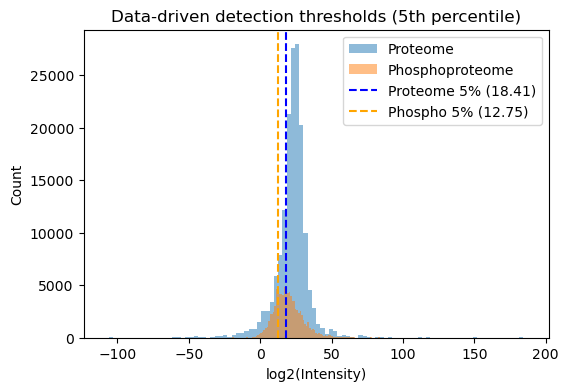

=== Detection summary per condition/timepoint ===


,proteome_detected,phospho_detected,overlap,unique_proteome,unique_phospho
10_CXCR7,1746,990,436,1310,554
600_CXCR7,1745,987,437,1308,550
1800_CXCR7,1746,990,439,1307,551
0_Ctrl,1746,985,436,1310,549
10_DMSO,1747,988,439,1308,549
600_DMSO,1748,988,435,1313,553
1800_DMSO,1744,983,434,1310,549


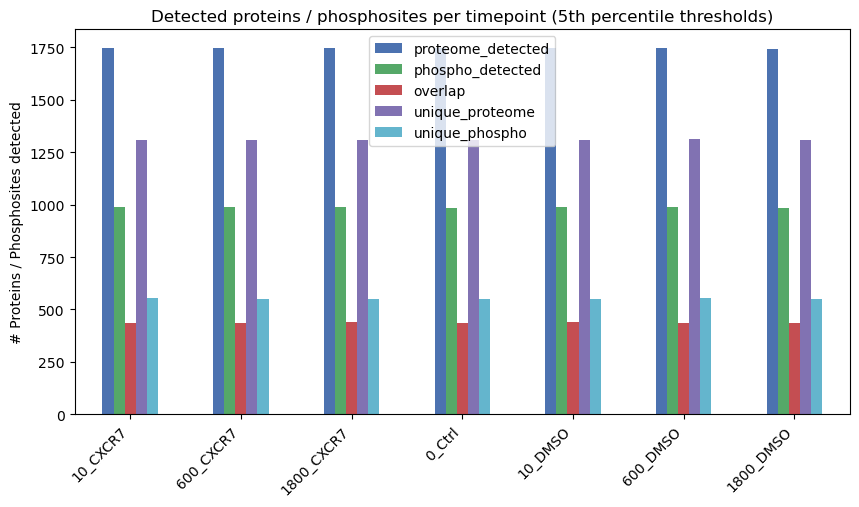

🧭 Global detection summary (5th percentile thresholds)
- Proteome detected IDs: 1753
- Phosphoproteome detected IDs: 1005
- Overlap (common UniProt IDs): 446
- Unique Proteome IDs: 1307
- Unique Phosphoproteome IDs: 559


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================================================
# 🧹 0. Clean and flatten numeric intensities
# ======================================================
def to_numeric(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(",", ".", regex=False)
                .replace(["NA", "NaN", "nan", "None", ""], np.nan)
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

prot_intensity_num = to_numeric(prot_intensity.drop(columns=["gene_symbol"], errors="ignore"))
phospho_intensity_num = to_numeric(phospho_intensity.drop(columns=["gene_symbol", "psite_id"], errors="ignore"))


# ======================================================
# ⚙️ 1. Determine data-driven thresholds
# ======================================================
q_prot = prot_intensity_num.stack().quantile(0.25)
q_phos = phospho_intensity_num.stack().quantile(0.25)

print(f"📊 Data-driven thresholds:")
print(f"- Proteome 5th percentile: {q_prot:.2f}")
print(f"- Phosphoproteome 5th percentile: {q_phos:.2f}")

# Optional: visualize with histogram
plt.figure(figsize=(6, 4))
plt.hist(prot_intensity_num.stack().dropna(), bins=100, alpha=0.5, label="Proteome")
plt.hist(phospho_intensity_num.stack().dropna(), bins=100, alpha=0.5, label="Phosphoproteome")
plt.axvline(q_prot, color="blue", linestyle="--", label=f"Proteome 5% ({q_prot:.2f})")
plt.axvline(q_phos, color="orange", linestyle="--", label=f"Phospho 5% ({q_phos:.2f})")
plt.xlabel("log2(Intensity)")
plt.ylabel("Count")
plt.legend()
plt.title("Data-driven detection thresholds (5th percentile)")
plt.show()


# ======================================================
# 🧮 2. Compute detection matrices
# ======================================================
def detection_table(df, threshold):
    df_num = to_numeric(df.drop(columns=["gene_symbol"], errors="ignore"))
    detected = df_num > threshold
    detected["gene_symbol"] = df["gene_symbol"]
    return detected

prot_detected = detection_table(prot_expr_mean, q_prot)
phospho_detected = detection_table(phospho_expr_mean, q_phos)


# ======================================================
# 📊 3. Count detected IDs per condition × timepoint
# ======================================================
def count_detected(detected_df):
    numeric_cols = [c for c in detected_df.columns if c != "gene_symbol"]
    counts = detected_df[numeric_cols].sum(axis=0)
    return counts

prot_counts = count_detected(prot_detected)
phospho_counts = count_detected(phospho_detected)

detection_summary = pd.DataFrame({
    "proteome_detected": prot_counts,
    "phospho_detected": phospho_counts
}).fillna(0).astype(int)

# overlap per timepoint
overlap_counts = []
for col in detection_summary.index:
    overlap = set(prot_detected.index[prot_detected[col]]) & set(phospho_detected.index[phospho_detected[col]])
    overlap_counts.append(len(overlap))
detection_summary["overlap"] = overlap_counts
detection_summary["unique_proteome"] = detection_summary["proteome_detected"] - detection_summary["overlap"]
detection_summary["unique_phospho"] = detection_summary["phospho_detected"] - detection_summary["overlap"]

print("=== Detection summary per condition/timepoint ===")
display(detection_summary)

# Optional bar plot
detection_summary.plot(
    kind="bar",
    figsize=(10,5),
    color=["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#64B5CD"],
    ylabel="# Proteins / Phosphosites detected"
)
plt.title("Detected proteins / phosphosites per timepoint (5th percentile thresholds)")
plt.xticks(rotation=45, ha="right")
plt.show()


# ======================================================
# 🧮 4. Global overlap summary
# ======================================================
all_prot_detected = set(prot_detected.index[(prot_detected.drop(columns=["gene_symbol"], errors="ignore")).any(axis=1)])
all_phospho_detected = set(phospho_detected.index[(phospho_detected.drop(columns=["gene_symbol"], errors="ignore")).any(axis=1)])

overlap_global = all_prot_detected & all_phospho_detected
unique_prot = all_prot_detected - overlap_global
unique_phospho = all_phospho_detected - overlap_global

print(f"🧭 Global detection summary (5th percentile thresholds)")
print(f"- Proteome detected IDs: {len(all_prot_detected)}")
print(f"- Phosphoproteome detected IDs: {len(all_phospho_detected)}")
print(f"- Overlap (common UniProt IDs): {len(overlap_global)}")
print(f"- Unique Proteome IDs: {len(unique_prot)}")
print(f"- Unique Phosphoproteome IDs: {len(unique_phospho)}")


## 6. Prepare Combined Expression Table (`expr_mean`)

In [116]:
# ======================================================
# 🧩 1. Prepare base tables
# ======================================================
prot_df = prot_expr_mean.copy()
phos_df = phospho_expr_mean.copy()

# unify column names (same timepoints)
prot_df = prot_df.rename_axis("UniProt")
phos_df = phos_df.rename_axis("UniProt")

# mark data source
prot_df["source"] = "proteome"
phos_df["source"] = "phosphoproteome"

# combine
combined = pd.concat([prot_df, phos_df], axis=0)

# ======================================================
# 🧩 2. Merge overlapping IDs intelligently
# ======================================================
# If both proteome and phosphoproteome exist → average or prefer phospho?
# We'll keep both values in separate columns and a merged "activity" value

# add flags
combined["has_proteome"] = combined.index.isin(prot_df.index)
combined["has_phospho"] = combined.index.isin(phos_df.index)

# merge on UniProt
merged = (
    prot_df.drop(columns=["gene_symbol"], errors="ignore")
    .add_suffix("_prot")
    .merge(
        phos_df.drop(columns=["gene_symbol"], errors="ignore").add_suffix("_phos"),
        left_index=True,
        right_index=True,
        how="outer"
    )
)

# merge gene symbols
gene_symbol_map = (
    pd.concat([prot_df["gene_symbol"], phos_df["gene_symbol"]])
    .groupby(level=0).first()
)
merged["gene_symbol"] = merged.index.map(gene_symbol_map)

# add origin flags
merged["has_proteome"] = merged.index.isin(prot_df.index)
merged["has_phospho"] = merged.index.isin(phos_df.index)

# ======================================================
# 🧮 3. Define an integrated “activity proxy”
# ======================================================
# If phospho data exists, use that; otherwise, fallback to proteome
expr_cols_phos = [c for c in merged.columns if "_phos" in c]
expr_cols_prot = [c for c in merged.columns if "_prot" in c]

for col_p, col_pr in zip(expr_cols_phos, expr_cols_prot):
    base_col = col_p.replace("_phos", "")
    merged[base_col + "_combined"] = merged[col_p].combine_first(merged[col_pr])

# ======================================================
# ✅ 4. Save and inspect
# ======================================================
print("=== Combined expression table (Proteome + Phosphoproteome) ===")
display(merged.head(5))

print(f"\nTotal merged entries: {len(merged)}")
print(f"- Both proteome + phospho: {(merged['has_proteome'] & merged['has_phospho']).sum()}")
print(f"- Proteome only: {(merged['has_proteome'] & ~merged['has_phospho']).sum()}")
print(f"- Phospho only: {(~merged['has_proteome'] & merged['has_phospho']).sum()}")


=== Combined expression table (Proteome + Phosphoproteome) ===


,10_CXCR7_prot,600_CXCR7_prot,1800_CXCR7_prot,0_Ctrl_prot,10_DMSO_prot,600_DMSO_prot,1800_DMSO_prot,source_prot,10_CXCR7_phos,600_CXCR7_phos,...,has_phospho,10_CXCR7_combined,600_CXCR7_combined,1800_CXCR7_combined,0_Ctrl_combined,10_DMSO_combined,600_DMSO_combined,1800_DMSO_combined,source_combined,haspho_combined
UniProt,,,,,,,,,,,,,,,,,,,,,
A0A075B6I0,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,proteome,NaN,NaN,...,False,32.300198,32.279510,32.241415,32.233940,32.208463,32.214118,32.282510,proteome,False
A0A0A0MS15,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,proteome,NaN,NaN,...,False,22.607773,22.514187,22.495981,22.369619,22.566267,22.504021,22.583532,proteome,False
A0A0B4J1U7,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,proteome,NaN,NaN,...,False,13.584549,13.543775,13.642663,13.532822,13.524586,13.556860,13.520838,proteome,False
A0A0B4J1X5,29.572116,29.697423,29.649465,29.559103,29.488391,29.691739,29.613414,proteome,NaN,NaN,...,False,29.572116,29.697423,29.649465,29.559103,29.488391,29.691739,29.613414,proteome,False
A0A0B4J1Y9,24.277022,24.283101,24.288321,24.264258,24.315194,24.220384,24.255841,proteome,NaN,NaN,...,False,24.277022,24.283101,24.288321,24.264258,24.315194,24.220384,24.255841,proteome,False



Total merged entries: 2915
- Both proteome + phospho: 726
- Proteome only: 1600
- Phospho only: 589


## 8. Save Outputs for OmniPath Network Analysis


In [118]:
from pathlib import Path

# ======================================================
# 📁 1. Define output directory
# ======================================================
base = Path(".")  # adjust if you run from a subfolder
out_dir = base / "analysis" / "networks" / "prepared_data"
out_dir.mkdir(parents=True, exist_ok=True)

# ======================================================
# 💾 2. Save all relevant preprocessed tables
# ======================================================

# --- Expression mean tables ---
prot_expr_mean.to_csv(out_dir / "proteome_expr_mean.csv")
phospho_expr_mean.to_csv(out_dir / "phosphoproteome_expr_mean.csv")
merged.to_csv(out_dir / "combined_expr_mean.csv")

# --- Fold-change tables ---
try:
    prot_fc.to_csv(out_dir / "proteome_fc.csv")
    phospho_fc.to_csv(out_dir / "phosphoproteome_fc.csv")
    print("Saved fold-change tables.")
except NameError:
    print("⚠️ FC tables not found in memory (prot_fc / phospho_fc). Skipping save.")

# --- Detected UniProt list ---
pd.Series(merged.index, name="UniProt").to_csv(out_dir / "detected_uniprots.txt", index=False)

# --- Summary report ---
print("✅ Saved prepared data for network analysis:")
print(f"- Proteome mean: {out_dir / 'proteome_expr_mean.csv'}")
print(f"- Phosphoproteome mean: {out_dir / 'phosphoproteome_expr_mean.csv'}")
print(f"- Combined mean table: {out_dir / 'combined_expr_mean.csv'}")
print(f"- Proteome FC: {out_dir / 'proteome_fc.csv'}")
print(f"- Phosphoproteome FC: {out_dir / 'phosphoproteome_fc.csv'}")
print(f"- Detected UniProt list: {out_dir / 'detected_uniprots.txt'}")

# Optional integrity check
for f in ["proteome_expr_mean.csv", "phosphoproteome_expr_mean.csv", "combined_expr_mean.csv"]:
    path = out_dir / f
    if path.exists():
        df_test = pd.read_csv(path, nrows=3)
        print(f"✅ Verified readable: {f} ({df_test.shape[1]} columns)")


Saved fold-change tables.
✅ Saved prepared data for network analysis:
- Proteome mean: analysis/networks/prepared_data/proteome_expr_mean.csv
- Phosphoproteome mean: analysis/networks/prepared_data/phosphoproteome_expr_mean.csv
- Combined mean table: analysis/networks/prepared_data/combined_expr_mean.csv
- Proteome FC: analysis/networks/prepared_data/proteome_fc.csv
- Phosphoproteome FC: analysis/networks/prepared_data/phosphoproteome_fc.csv
- Detected UniProt list: analysis/networks/prepared_data/detected_uniprots.txt
✅ Verified readable: proteome_expr_mean.csv (9 columns)
✅ Verified readable: phosphoproteome_expr_mean.csv (9 columns)
✅ Verified readable: combined_expr_mean.csv (29 columns)


In [120]:
# ======================================================
# 📦 Save prepared node-level data, including phospho_intensity
# ======================================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# 📁 1. Define output directory
# ======================================================
base = Path(".")  # adjust if you run from a subfolder
out_dir = base / "analysis" / "networks" / "prepared_data"
out_dir.mkdir(parents=True, exist_ok=True)

# ======================================================
# 💾 2. Save all relevant preprocessed tables
# ======================================================

# --- Expression mean tables ---
prot_expr_mean.to_csv(out_dir / "proteome_expr_mean.csv")
phospho_expr_mean.to_csv(out_dir / "phosphoproteome_expr_mean.csv")
merged.to_csv(out_dir / "combined_expr_mean.csv")

# --- Fold-change tables ---
try:
    prot_fc.to_csv(out_dir / "proteome_fc.csv")
    phospho_fc.to_csv(out_dir / "phosphoproteome_fc.csv")
    print("Saved fold-change tables.")
except NameError:
    print("⚠️ FC tables not found in memory (prot_fc / phospho_fc). Skipping save.")

# --- Detected UniProt list ---
pd.Series(merged.index, name="UniProt").to_csv(out_dir / "detected_uniprots.txt", index=False)

# ======================================================
# 📊 3. Handle phospho_intensity table (if available)
# ======================================================
try:
    print("\n=======================================================")
    print("📊 Inspecting phospho_intensity table")
    print("=======================================================")
    
    # Basic info
    print(f"Shape: {phospho_intensity.shape}")
    print(f"Columns: {list(phospho_intensity.columns)[:100]}{'...' if phospho_intensity.shape[1] > 10 else ''}")
    print(f"Index (first 5): {list(phospho_intensity.index[:5])}")

    # Save table
    phospho_intensity.to_csv(out_dir / "phospho_intensity.csv")
    print(f"✅ Saved phospho_intensity table to: {out_dir / 'phospho_intensity.csv'}")

    # ======================================================
    # 🎨 4. Quick overview plot (heatmap)
    # ======================================================
    # Detect only numeric columns for plotting
    numeric_cols = phospho_intensity.select_dtypes(include='number').columns
    if len(numeric_cols) > 1:
        sample = phospho_intensity[numeric_cols].sample(
            n=min(100, phospho_intensity.shape[0]), random_state=42
        )

        plt.figure(figsize=(10, 6))
        sns.heatmap(sample, cmap="coolwarm", center=0)
        plt.title("Phospho Intensity (random 100 sites)", fontsize=14, pad=15)
        plt.xlabel("Samples / Conditions")
        plt.ylabel("Phosphosites")
        plt.tight_layout()
        plt.savefig(out_dir / "phospho_intensity_heatmap.png", dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Saved phospho_intensity heatmap to: {out_dir / 'phospho_intensity_heatmap.png'}")
    else:
        print("⚠️ phospho_intensity does not have numeric columns for heatmap plotting.")

except NameError:
    print("⚠️ phospho_intensity table not found in memory. Skipping.")

# ======================================================
# ✅ Summary report
# ======================================================
print("\n✅ Saved prepared data for network analysis:")
print(f"- Proteome mean: {out_dir / 'proteome_expr_mean.csv'}")
print(f"- Phosphoproteome mean: {out_dir / 'phosphoproteome_expr_mean.csv'}")
print(f"- Combined mean table: {out_dir / 'combined_expr_mean.csv'}")
print(f"- Proteome FC: {out_dir / 'proteome_fc.csv'}")
print(f"- Phosphoproteome FC: {out_dir / 'phosphoproteome_fc.csv'}")
print(f"- Detected UniProt list: {out_dir / 'detected_uniprots.txt'}")
print(f"- Phospho intensity: {out_dir / 'phospho_intensity.csv'} (if available)")

# ======================================================
# 🔍 5. Optional integrity check
# ======================================================
for f in [
    "proteome_expr_mean.csv", 
    "phosphoproteome_expr_mean.csv", 
    "combined_expr_mean.csv", 
    "phospho_intensity.csv"
]:
    path = out_dir / f
    if path.exists():
        df_test = pd.read_csv(path, nrows=3)
        print(f"✅ Verified readable: {f} ({df_test.shape[1]} columns)")


Saved fold-change tables.

📊 Inspecting phospho_intensity table
Shape: (1315, 72)
Columns: ['0000_Ctrl_01', '0000_Ctrl_02', '0000_Ctrl_03', '0000_Ctrl_04', '0000_Ctrl_05', '0000_Ctrl_06', '0000_Ctrl_07', '0000_Ctrl_08', '0000_Ctrl_09', '0000_Ctrl_10', '0010_CXCR7_01', '0010_CXCR7_02', '0010_CXCR7_03', '0010_CXCR7_04', '0010_CXCR7_05', '0010_CXCR7_06', '0010_CXCR7_07', '0010_CXCR7_08', '0010_CXCR7_09', '0010_CXCR7_10', '0010_DMSO_01', '0010_DMSO_02', '0010_DMSO_03', '0010_DMSO_04', '0010_DMSO_05', '0010_DMSO_06', '0010_DMSO_07', '0010_DMSO_08', '0010_DMSO_09', '0010_DMSO_10', '0600_CXCR7_01', '0600_CXCR7_02', '0600_CXCR7_03', '0600_CXCR7_04', '0600_CXCR7_05', '0600_CXCR7_06', '0600_CXCR7_07', '0600_CXCR7_08', '0600_CXCR7_09', '0600_CXCR7_10', '0600_DMSO_01', '0600_DMSO_02', '0600_DMSO_03', '0600_DMSO_04', '0600_DMSO_05', '0600_DMSO_06', '0600_DMSO_07', '0600_DMSO_08', '0600_DMSO_09', '0600_DMSO_10', '1800_CXCR7_01', '1800_CXCR7_02', '1800_CXCR7_03', '1800_CXCR7_04', '1800_CXCR7_05', '18